In [1]:
from dotenv import load_dotenv
import os
import dotenv
import pandas as pd
import re
import sqlalchemy
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.transforms as mtransforms
import matplotlib.ticker as ticker
import requests
import json

In [ ]:
data_path = r'C:\Users\johnm\Code\RRC_Pipeline\assets\CSV\OG_COUNTY_CYCLE_DATA_TABLE.csv'
df = pd.read_csv(data_path, dtype={'COUNTY_NO': str})

<bound method NDFrame.head of        COUNTY_NO  DISTRICT_NO  CYCLE_YEAR  CYCLE_MONTH  CYCLE_YEAR_MONTH  \
0            001            5        1993            1            199301   
1            001            5        1993            2            199302   
2            001            5        1993            3            199303   
3            001            5        1993            4            199304   
4            001            5        1993            5            199305   
...          ...          ...         ...          ...               ...   
231082       507            1        2024            9            202409   
231083       507            1        2024           10            202410   
231084       507            1        2024           10            202410   
231085       507            1        2024           11            202411   
231086       507            1        2024           11            202411   

        CNTY_OIL_PROD_VOL  CNTY_OIL_ALLOW  CNTY_OIL_ENDIN

C:\Users\johnm\AppData\Local\Temp\ipykernel_24148\2066429703.py:2: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, dtype={'COUNTY_NO': str})


In [3]:
# Data integrity checks
# print(df.columns)S
# print(len(df['DISCTRICT_NAME'].isna()))

In [4]:
# Columns of original data series
# print(df.columns)

# Counties that have oil production - duplicates exist
counties = df.loc[df['CNTY_COND_PROD_VOL'] > 0, 'COUNTY_NAME']

# Number of unique counties that have oil production
unique_counties = pd.unique(counties)
print("Number of unique counties that have oil production: ", len(unique_counties))

# How many counties in Texas are there?
print("How many counties in Texas are there? ", len(pd.unique(df['COUNTY_NAME'])))


Number of unique counties that have oil production:  206
How many counties in Texas are there?  254


In [5]:
# Slider on year that you can see a heatmap of production over every year
# Create a map that has counties displayed in the map:

map_path = r'C:\Users\johnm\Code\RRC_Pipeline\assets\lat-long-us.csv'
new_csv = r'C:\Users\johnm\Code\RRC_Pipeline\assets\combined.csv'
df_map = pd.read_csv(map_path)

df_map = pd.read_csv(map_path, dtype={'fips_code': str}) # Read csv
df_map['is_fips_code'] = df_map['fips_code'].str[:2] == '48' # Captures the shortened fips code
df_map = df_map[df_map['is_fips_code']].reset_index(drop=True) # Creates a new dataframe without the entries that are not '48'
df_map['fips_code'] = df_map['fips_code'].str[2:] # Removing '48' from each entry for future comparisons
df_map = df_map[df_map['is_fips_code']].drop(columns=['is_fips_code']) # Dropping is_fips_code
df_map = df_map.set_index('fips_code') # Setting index to fips_code so merge will work on index
df['COUNTY_NO'] = df['COUNTY_NO'].astype(str) #Ensures the dataframe, df, has county_no's (fips codes) that are a string type.

df = df.merge(df_map, left_on='COUNTY_NO', right_index=True, how = 'left') #Merges lookup_df with df


In [9]:
# Get the total oil production per day over 1993-2023 - 
# change PBI to display average across all years

# Discrepencies between RRC and EIA data
# Checked adding in total disposed oil which is a numeric amount has a positive value and represents the barrels of oil disposed of for oil leases by county. This is an estimated value. 
# Checked county gas production

df["YEAR"] = df["CYCLE_YEAR"].astype(str).str[:4]
unique_years = pd.unique(df["YEAR"])
year_prod = df[["YEAR", "CNTY_OIL_PROD_VOL", "CNTY_COND_PROD_VOL"]].copy()
year_prod["COMBINED"] = year_prod["CNTY_OIL_PROD_VOL"] + year_prod["CNTY_COND_PROD_VOL"]

sum_array = []
for year in unique_years:
    year_prod_vol = year_prod[year_prod["YEAR"] == year]
    year_sum = year_prod_vol["COMBINED"].sum()
    sum_array.append(year_sum/365)
    print("Year: ", str(year))
    print("Oil Production: ", str((year_sum/365).round(decimals = 2)), "Barrels per day")

Year:  1993
Oil Production:  1678073.13 Barrels per day
Year:  1994
Oil Production:  1593234.08 Barrels per day
Year:  1995
Oil Production:  1512879.5 Barrels per day
Year:  1996
Oil Production:  1476805.92 Barrels per day
Year:  1997
Oil Production:  1454431.33 Barrels per day
Year:  1998
Oil Production:  1368161.65 Barrels per day
Year:  1999
Oil Production:  1220649.75 Barrels per day
Year:  2000
Oil Production:  1201274.76 Barrels per day
Year:  2001
Oil Production:  1152372.25 Barrels per day
Year:  2002
Oil Production:  1111672.71 Barrels per day
Year:  2003
Oil Production:  1097698.58 Barrels per day
Year:  2004
Oil Production:  1076019.24 Barrels per day
Year:  2005
Oil Production:  1075619.88 Barrels per day
Year:  2006
Oil Production:  1075271.21 Barrels per day
Year:  2007
Oil Production:  1071885.87 Barrels per day
Year:  2008
Oil Production:  1112063.95 Barrels per day
Year:  2009
Oil Production:  1094004.47 Barrels per day
Year:  2010
Oil Production:  1169478.82 Barrels p

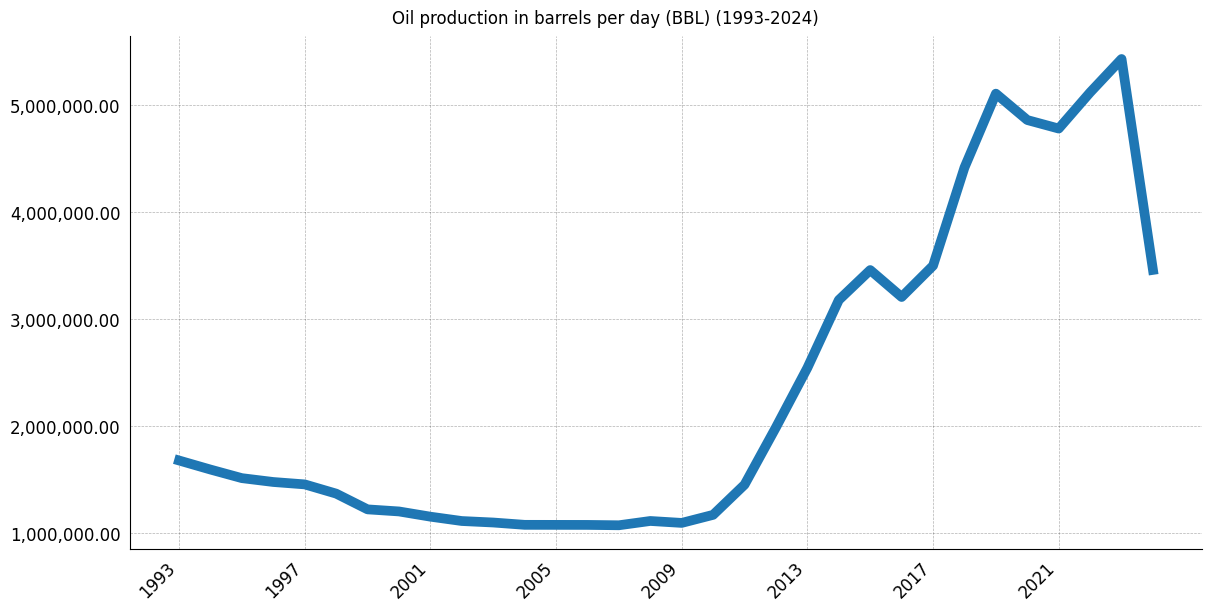

In [10]:
# Plot
# https://matplotlib.org/stable/gallery/showcase/stock_prices.html#sphx-glr-gallery-showcase-stock-prices-py
fig, ax = plt.subplots(1, 1, figsize=(12, 6), layout='constrained')
line, = ax.plot(unique_years, sum_array, lw=7)

# Title
fig.suptitle("Oil production in barrels per day (BBL) (1993-2024)", ha="center")

# Grid
ax.grid(True, 'major', 'both', ls='--', lw=.5, c='k', alpha=.3)

ax.tick_params(
    axis='both', which='both', labelsize='large', 
    bottom=False, top=False, labelbottom=True, 
    left=False, right=False, labelleft=True
)

# Format x-axis
ax.set_xticks(unique_years[::4])
plt.xticks(rotation=45, ha='right')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))

# Make only left and bottom spines visible
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()


In [11]:
# Getting brent and wti data from FRED API
brent_url = r'https://api.stlouisfed.org/fred/series/observations?series_id=DCOILBRENTEU&realtime_start=1776-07-04&realtime_end=9999-12-31'
wti_url = r'https://api.stlouisfed.org/fred/series/observations?series_id=DCOILWTICO&realtime_start=1776-07-04&realtime_end=9999-12-31'
links = [brent_url, wti_url]

api_key_base = os.environ.get('FRED_API_KEY')
api_key = '&api_key=' + str(api_key_base) + '&file_type=json'

# Brent
brent_request = requests.get(brent_url + api_key)
json_item = json.loads(brent_request.text)
json_item = json_item["observations"]
df_brent = pd.DataFrame(json_item)
print(df_brent.shape)
print("Brent")
print(df_brent.head)
print(df_brent.columns)
print(df_brent.shape)

# WTI
wti_request = requests.get(wti_url + api_key)
json_item = json.loads(wti_request.text)
json_item = json_item["observations"]
df_wti = pd.DataFrame(json_item)

print("WTI")
print(df_wti.head)
print(df_wti.columns)
print(df_wti.shape)

(9874, 4)
Brent
<bound method NDFrame.head of      realtime_start realtime_end        date  value
0        2011-04-06   9999-12-31  1987-05-20  18.63
1        2011-04-06   9999-12-31  1987-05-21  18.45
2        2011-04-06   9999-12-31  1987-05-22  18.55
3        2011-04-06   9999-12-31  1987-05-25  18.60
4        2011-04-06   9999-12-31  1987-05-26  18.63
...             ...          ...         ...    ...
9869     2024-12-18   9999-12-31  2024-12-10  73.64
9870     2024-12-18   9999-12-31  2024-12-11  74.38
9871     2024-12-18   9999-12-31  2024-12-12  73.52
9872     2024-12-18   9999-12-31  2024-12-13  74.89
9873     2024-12-18   9999-12-31  2024-12-16   74.3

[9874 rows x 4 columns]>
Index(['realtime_start', 'realtime_end', 'date', 'value'], dtype='object')
(9874, 4)
WTI
<bound method NDFrame.head of       realtime_start realtime_end        date  value
0         2011-04-06   9999-12-31  1986-01-02  25.56
1         2011-04-06   9999-12-31  1986-01-03  26.00
2         2011-04-06   999

In [67]:
# Coercing 'date' to a datetime and 'value' to float
df_wti["date"] = pd.to_datetime(df_wti["date"])
df_wti["value"] = pd.to_numeric(df_wti["value"], errors='coerce')

# Creating a new column which represents the month of the value
df_wti["year_month"] = df_wti["date"].dt.to_period("M").astype(str)

# Obtaining the unique months
unique_months = pd.unique(df_wti["year_month"])

# Aggregate by month
sum_array = []
for month in unique_months:
    wti_month_prod_vol = df_wti[df_wti["year_month"] == month]
    month_sum = wti_month_prod_vol["value"].sum()
    sum_array.append(month_sum)

# Create final DataFrame
data_dict = {"month": unique_months , "value": sum_array}
df_wti_month = pd.DataFrame(data = data_dict)
print(df_wti_month.head())
print(df_wti_month.shape) 

     month  value
0  1986-01  492.0
1  1986-02  285.0
2  1986-03  244.0
3  1986-04  271.0
4  1986-05  313.0
(468, 2)


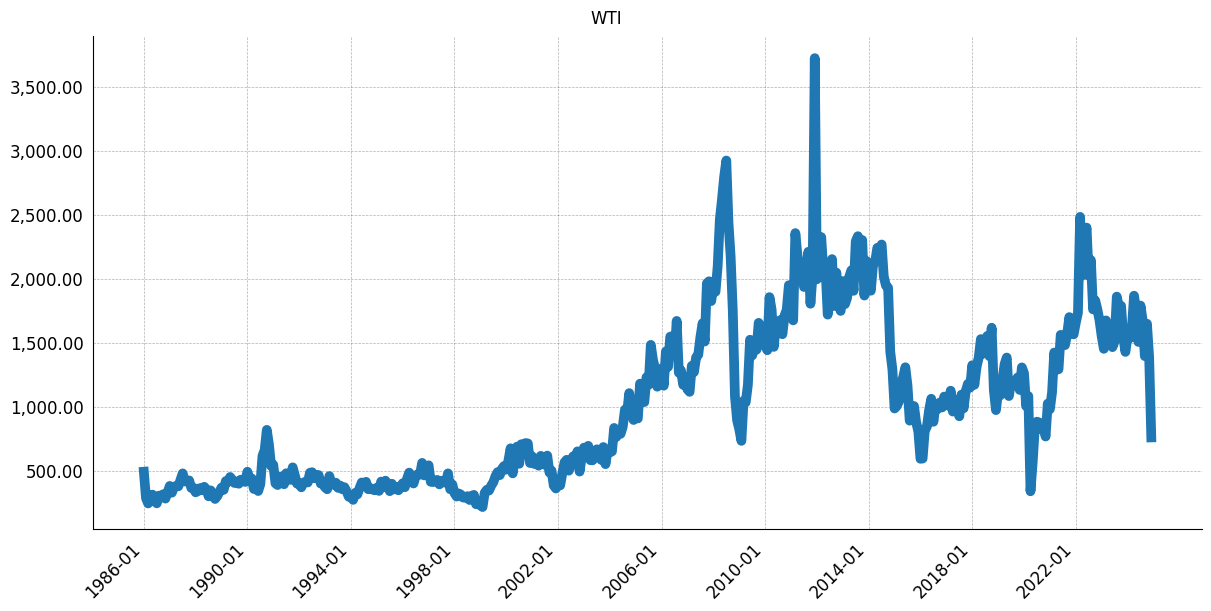

In [68]:
# Plot
# https://matplotlib.org/stable/gallery/showcase/stock_prices.html#sphx-glr-gallery-showcase-stock-prices-py
fig, ax = plt.subplots(1, 1, figsize=(12, 6), layout='constrained')
line, = ax.plot(df_wti_month["month"], df_wti_month["value"], lw=7)

# Title
fig.suptitle("WTI", ha="center")

# Grid
ax.grid(True, 'major', 'both', ls='--', lw=.5, c='k', alpha=.3)

ax.tick_params(
    axis='both', which='both', labelsize='large', 
    bottom=False, top=False, labelbottom=True, 
    left=False, right=False, labelleft=True
)

# Format x-axis
ax.set_xticks(df_wti_month["month"][::48])
plt.xticks(rotation=45, ha='right')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))

# Make only left and bottom spines visible
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))



In [72]:
eia_oil_prod = r'https://api.eia.gov/v2/petroleum/sum/snd/data/?frequency=monthly&data[0]=value&facets[series][]=MCRFPUS2&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000'

api_key_base = os.environ.get('EIA_API_KEY')
api_key = '&api_key=' + str(api_key_base)
eia_oil_prod_request = requests.get(eia_oil_prod + api_key)

json_item = json.loads(eia_oil_prod_request.text)
json_data = json_item.get('response').get('data')

# sum_array = []
# for year in unique_years:
#     year_prod_vol = year_prod[year_prod["period"] == year]
#     year_sum = year_prod_vol["COMBINED"].sum()
#     sum_array.append(year_sum/365)
#     print("Year: ", str(year))
#     print("Oil Production: ", str((year_sum/365).round(decimals = 2)), "Barrels per day")


In [79]:
df_us_prod = pd.DataFrame(json_data)
print(df_us_prod.head())

df_us_prod["period"] = pd.to_datetime(df_us_prod["period"])

    period duoarea area-name product product-name process      process-name  \
0  2024-09     NUS      U.S.    EPC0    Crude Oil     FPF  Field Production   
1  2024-08     NUS      U.S.    EPC0    Crude Oil     FPF  Field Production   
2  2024-07     NUS      U.S.    EPC0    Crude Oil     FPF  Field Production   
3  2024-06     NUS      U.S.    EPC0    Crude Oil     FPF  Field Production   
4  2024-05     NUS      U.S.    EPC0    Crude Oil     FPF  Field Production   

     series                                 series-description  value   units  
0  MCRFPUS2  U.S. Field Production of Crude Oil (Thousand B...  13204  MBBL/D  
1  MCRFPUS2  U.S. Field Production of Crude Oil (Thousand B...  13361  MBBL/D  
2  MCRFPUS2  U.S. Field Production of Crude Oil (Thousand B...  13192  MBBL/D  
3  MCRFPUS2  U.S. Field Production of Crude Oil (Thousand B...  13240  MBBL/D  
4  MCRFPUS2  U.S. Field Production of Crude Oil (Thousand B...  13201  MBBL/D  


Index(['month', 'value_x', 'duoarea', 'area-name', 'product', 'product-name',
       'process', 'process-name', 'series', 'series-description', 'value_y',
       'units'],
      dtype='object')


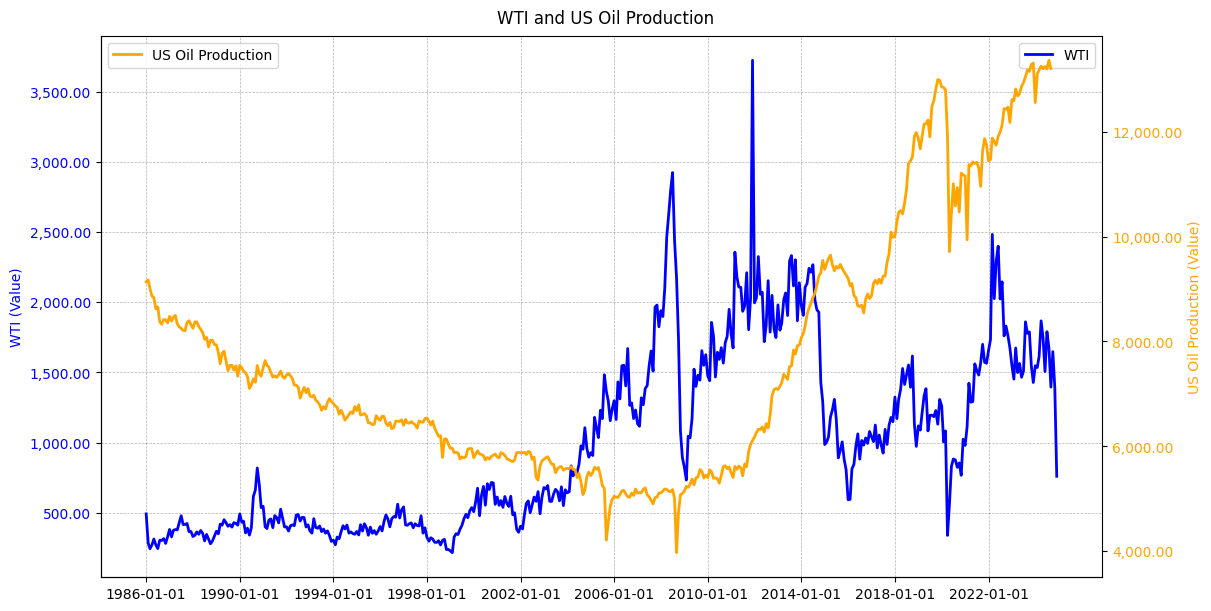

In [107]:
df_wti_month["month"] = pd.to_datetime(df_wti_month["month"])
if 'period' in df_us_prod.columns:
    df_us_prod = df_us_prod.set_index('period') 

# Merging WTI and EIA oil production data frames
df_merged = df_wti_month.merge(df_us_prod, left_on='month', right_index=True, how = 'left') #Merges lookup_df with df'README.txt

# Ensure 'value_x' and 'value_y' columns are numeric and handle NaN values
df_merged["value_x"] = pd.to_numeric(df_merged["value_x"], errors='coerce')
df_merged["value_y"] = pd.to_numeric(df_merged["value_y"], errors='coerce')

print(df_merged.columns)
# https://matplotlib.org/stable/gallery/showcase/stock_prices.html#sphx-glr-gallery-showcase-stock-prices-py

# Rename specific columns
df_merged.rename(columns={
    "value_x": "WTI_Value",
    "value_y": "US_Production_Value"
}, inplace=True)
fig, ax_left = plt.subplots(1, 1, figsize=(12, 6), layout='constrained')


# Plot the first series (WTI)
# ax.plot(df_merged["month"], df_merged["value_x"], label="WTI", lw=2, color='blue')

# # Plot the second series (US Production Values)
# ax.plot(df_merged["month"], df_merged["value_y"], label="US Oil Production", lw=2, color='orange')

# Plot WTI values on the left y-axis
ax_left.plot(df_merged["month"], df_merged["WTI_Value"], label="WTI", lw=2, color='blue')
ax_left.set_ylabel("WTI (Value)", color='blue')
ax_left.tick_params(axis='y', labelcolor='blue')
ax_left.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))

# Add a twin axes for US Oil Production values
ax_right = ax_left.twinx()
ax_right.plot(df_merged["month"], df_merged["US_Production_Value"], label="US Oil Production", lw=2, color='orange')
ax_right.set_ylabel("US Oil Production (Value)", color='orange')
ax_right.tick_params(axis='y', labelcolor='orange')
ax_right.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))

# Titles and labels
fig.suptitle("WTI and US Oil Production", ha="center")
ax.set_xlabel("Month")
ax_left.grid(True, 'major', 'both', ls='--', lw=0.5, c='k', alpha=0.3)

# Grid
# ax.grid(True, 'major', 'both', ls='--', lw=.5, c='k', alpha=.3)

# ax.tick_params(
#     axis='both', which='both', labelsize='large', 
#     bottom=False, top=False, labelbottom=True, 
#     left=False, right=False, labelleft=True
# )

# Format x-axis
ax_left.set_xticks(df_merged["month"][::48])
plt.xticks(rotation=45, ha='right')
# ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))

# Make only left and bottom spines visible
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# Customize spines
ax_left.spines['top'].set_visible(False)
ax_left.spines['right'].set_visible(False)

# Add legend
ax_left.legend()
ax_right.legend()

plt.show()

# ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))

plt.show()

In [23]:
with open (r'assets/EIA/eia_codes.json', 'r') as f:
    json_item = json.load(f)

for num in range(len(json_item)):
    objects = json_item[str(num)]['object']

    for obj in objects:
        code = obj['code']
        print(code)


# Left off on page 20 of EIA data table
# https://www.eia.gov/opendata/browser/total-energy?frequency=monthly&data=value;&start=2024-01&end=2025-12&sortColumn=period;&sortDirection=desc;

VTTWPUS
PATWPUS
PATCPUS
PAIMPUS
PANIPUS
PAIMPUS
PAIMPPG
PAIMPOP
PAEXPUS
OGWSPUS
OGTWPUS
CPUCIUS
COSXPUS
COSQPUS
COEXPUS
COSXPUS


In [ ]:
eia_oil_prod = r'https://api.eia.gov/v2/petroleum/sum/snd/data/?frequency=monthly&data[0]=value&facets[series][]=' + 'MCRFPUS2' + '&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000'

api_key_base = os.environ.get('EIA_API_KEY')
api_key = '&api_key=' + str(api_key_base)
eia_oil_prod_request = requests.get(eia_oil_prod + api_key)

json_item = json.loads(eia_oil_prod_request.text)
json_data = json_item.get('response').get('data')

In [1]:
# Chart the log price of WTI and oil imports to U.S.

# How could you simulate the policy effect of an increase in tariffs and an increase in oil production?

# Chart US oil reserves as well

# Romer recession dates - from Bernanke paper

# EIA paper saying that less oil rigs and increasing production mean that each rig is becoming more productive - because of technological increases
#  ->https://www.eia.gov/todayinenergy/detail.php?id=64124

# What about the natural gas story - where gas can't be moved because of limited pipelines causing prices to fall below zero

In [ ]:
# g more productive - because of technological increases
#  ->https://www.eia.gov/todayinenergy/detail.php?id=64124

# What about the natural gas story - where gas can't be moved because of limited pipelines causing prices to fall below zero

21:30:02 - cmdstanpy - INFO - Chain [1] start processing
21:30:02 - cmdstanpy - INFO - Chain [1] done processing


<bound method NDFrame.head of          month  WTI_Value duoarea area-name product product-name process  \
0   1986-01-01      492.0     NUS      U.S.    EPC0    Crude Oil     FPF   
1   1986-02-01      285.0     NUS      U.S.    EPC0    Crude Oil     FPF   
2   1986-03-01      244.0     NUS      U.S.    EPC0    Crude Oil     FPF   
3   1986-04-01      271.0     NUS      U.S.    EPC0    Crude Oil     FPF   
4   1986-05-01      313.0     NUS      U.S.    EPC0    Crude Oil     FPF   
..         ...        ...     ...       ...     ...          ...     ...   
463 2024-08-01     1674.0     NUS      U.S.    EPC0    Crude Oil     FPF   
464 2024-09-01     1395.0     NUS      U.S.    EPC0    Crude Oil     FPF   
465 2024-10-01     1648.0     NaN       NaN     NaN          NaN     NaN   
466 2024-11-01     1389.0     NaN       NaN     NaN          NaN     NaN   
467 2024-12-01      760.0     NaN       NaN     NaN          NaN     NaN   

         process-name    series  \
0    Field Production 

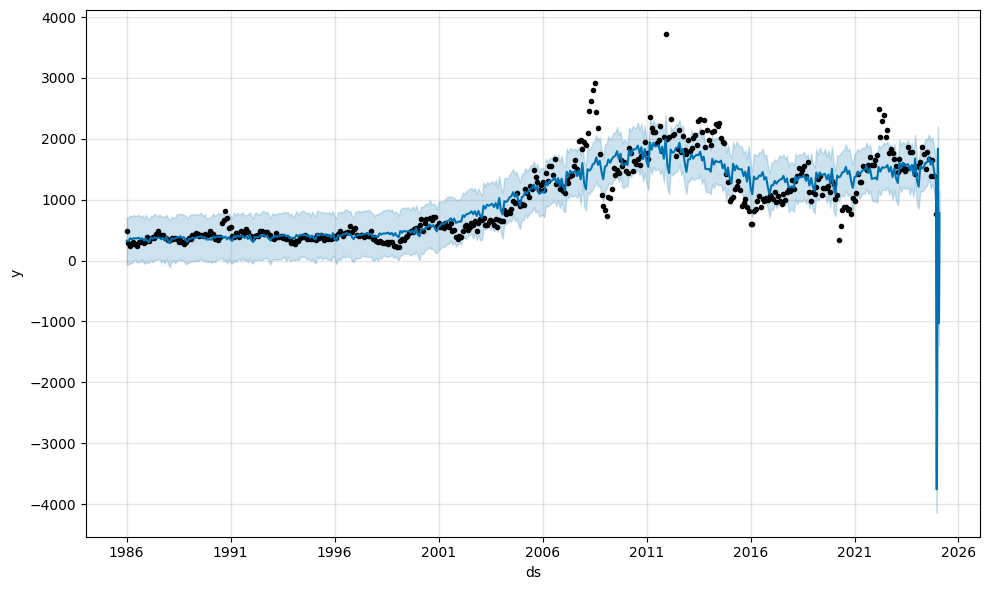

21:30:02 - cmdstanpy - INFO - Chain [1] start processing
21:30:02 - cmdstanpy - INFO - Chain [1] done processing


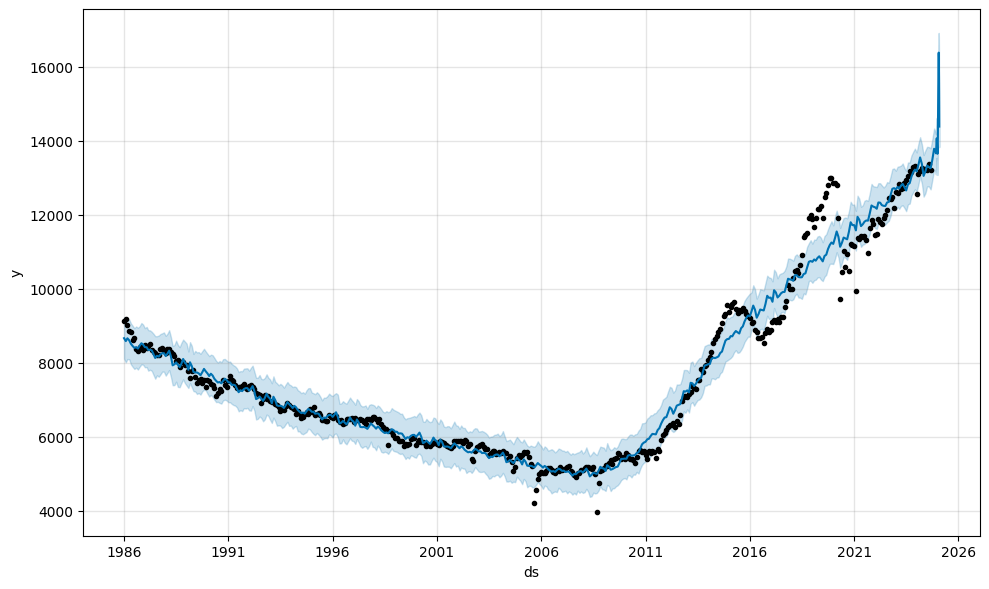

In [110]:
from prophet import Prophet

print(df_merged.head)
print(df_merged.columns)
model = Prophet(seasonality_mode='multiplicative')
df_wti_subset = df_merged[["month", "WTI_Value"]]
df_wti_subset.columns = ["ds", "y"]
model.fit(df_wti_subset)
future = model.make_future_dataframe(periods = 12*5)
forecast = model.predict(future)
fig = model.plot(forecast)
plt.show()

model_2 = Prophet(seasonality_mode='multiplicative')
df_eia_subset = df_merged[["month", "US_Production_Value"]]
df_eia_subset.columns = ["ds", "y"]
model_2.fit(df_eia_subset)
future = model_2.make_future_dataframe(periods = 12*5)
forecast = model_2.predict(future)
fig = model_2.plot(forecast)
plt.show()


In [ ]:
# To do:

# The actual forecast is skewed - keep reading book

In [13]:
# Expenses or costs of production

# Does this data give anything on byproducts of wells or byproducts that can be used for other purposes?

# Find top 10 conties for 2023 production

# Find top 10 counties for 1993 production

# Number of wells in the permian over time

# Can I sample data using a model anadd

In [14]:
# print(df.head)
# df.to_csv(new_csv, index=False)

In [15]:
# load_dotenv()
# DATABASE_URL = os.getenv('DATABASE_URL')

# try:
#     df.to_sql(name="OG_COUNTY_CYCLE_DATA_TABLE", con=engine)
# except Exception as e:
#     print(e)

# from sqlalchemy import text
# with engine.connect() as conn:
#     result = conn.execute(text('SELECT * FROM "OG_COUNTY_CYCLE_DATA_TABLE" LIMIT 10')).fetchall()

# for index,row in enumerate(result):
#     print(result[index])
#     # print(len(result))
